# Evaluation

Load trained model, predict on the test data, save all the results.

In [1]:
'''Only run once'''
from pathlib import Path
import os
os.chdir(Path.cwd().parent) # set the correct working directory

from evaluation.evaluation import *
from __future__ import annotations
from xflow import ConfigManager, FileProvider, PyTorchPipeline, show_model_info
from xflow.data import build_transforms_from_config
from xflow.utils import load_validated_config, save_image, plot_image

import torch
import os
from datetime import datetime  
from config_utils import load_config
import pandas as pd
import numpy as np

from utils import *

def fixed_process(experiments, experiment, count, batch_size=None, change_val_dir=None):
  # Load the trained model
  from models.CAE import Autoencoder2D
  from models.ERN import EncoderRegressor
  from models.Pix2pix import Generator
  from models.SHL_DNN import SHLNeuralNetwork
  from models.SwinT import SwinUNet
  from models.TM import TransmissionMatrix
  from models.U_Net import UNet

  from functools import partial
  from xflow.extensions.physics.beam import extract_beam_parameters

  extract_beam_parameters = partial(extract_beam_parameters, as_array=False)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  experiment_name = Path(experiment).name.split("-")[0] 
  dir_yaml = Path(experiment) / (experiment_name.split("-")[0] + ".yaml")
  config_manager = ConfigManager(load_config(exp_name=dir_yaml, prior_machine=True))
  config = config_manager.get()
  if batch_size is not None: # fix and unify batch size for evaluation
      config["data"]["dataset_ops"][0]['params']['batch_size'] = batch_size 

  # ==================== 
  # Prepare Dataset
  # ====================
  if change_val_dir is not None:
      config["data"]["evaluation_set"] = change_val_dir
      config["data"]["train_val_split"] = 0.0
      config["data"]["val_test_split"] = 0.0
  evaluation_folder = os.path.join(config['paths']['datasets']['mmf'], config["data"]["evaluation_set"])
  evaluation_provider = FileProvider(evaluation_folder).\
      subsample(fraction=config["data"]["subsample_fraction"], seed=config["seed"]) 
  val_provider, test_provider = evaluation_provider.\
      split(ratio=config["data"]["val_test_split"], seed=config["seed"])
  transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])
  def make_dataset(provider):
      return PyTorchPipeline(provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

  test_dataset = make_dataset(test_provider)
  print("Samples: ", len(test_provider))
  print("Batch: ", len(test_dataset))
  print(f'processing: {experiment_name}, model left to evaluate: {count+1}/{len(experiments)}')

  if experiment_name == "CAE":
      model = Autoencoder2D.load_model(experiment + '/model.pth', device=device)
      mode = "img2img"
  elif experiment_name == "ERN":
      model = EncoderRegressor.load_model(experiment + '/model.pth', device=device)
      mode = "regression"
  elif experiment_name == "Pix2pix":
      model = Generator.load_model(experiment + '/model.pth', device=device)
      mode = "img2img"
  elif experiment_name == "SHL_DNN":
      model = SHLNeuralNetwork.load_model(experiment + '/model.pth', device=device)
      mode = "flattened"
  elif experiment_name == "SwinT":
      model = SwinUNet.load_model(experiment + '/model.pth', device=device)
      mode = "img2img"
  elif experiment_name == "TM":
      model = TransmissionMatrix.load_model(experiment + '/model.pth', device=device)
      mode = "flattened"
  elif experiment_name == "U_Net":
      model = UNet.load_model(experiment + '/model.pth', device=device)
      mode = "img2img"

  return {
          'model': model, 'test_dataset': test_dataset, 
          'device': device, 'extract_beam_parameters': extract_beam_parameters, 
          'mode': mode, 'experiment_name': experiment_name, 'experiment_id': str(Path(experiment).name),
          'config': config
          }

In [ ]:

'''Model evaluation on the test set'''

experiments = list_subfolders_abs('results/HPC/')
[print(i) for i in experiments]

for count, experiment in enumerate(experiments):
    # loop over each results
    read_outs = fixed_process(experiments, experiment, count)
    # 1. get pure prediction results with ground truth as a clear table
    read_outs['model'].eval()  # Set to evaluation mode
    df = evaluate_to_df(
        model=read_outs['model'],
        test_loader=read_outs['test_dataset'],
        device=read_outs['device'],
        extract_beam_parameters=read_outs['extract_beam_parameters'],
        mode=read_outs['mode'],
    )
    # 2. add futher calculation to the table (just do it inmemory)
    thresholds = {"MAE": 0.05, "RMSE": 0.05, "MSE": 0.05}
    df = add_beamparam_metrics(df)
    df = add_extraction_state_and_thresholds(df, thresholds)
    df.to_csv("results/metrics/{}.csv".format(Path(experiment).name), index=False)
    summarize_error_columns_to_json(df, "results/metrics/{}_summary.json".format(Path(experiment).name))

In [ ]:
'''tiny quick sanity check'''
df = pd.read_csv("results/metrics/CAE-20250825044452.csv")
# df = pd.read_csv("results/metrics/CAE-20250825064523.csv")
plot_sanity(df)

# FIG-1 Training statistics

In [ ]:
# copy all the training information into a single folder
collect_and_copy_by_keyword(src_dir="results/HPC/", dst_dir="results/metrics", keyword="history.json")

In [ ]:
metrics = [
  "train_loss",
  # "val_loss",
  "val_overall_mae",
  "val_overall_mse",
  "val_overall_rmse"
]

ratio = 2
set_aps_single_column(figsize=(3.25*ratio, 2.5*ratio), scale=1.4)
for m in metrics:
    plot_history_curves(folder='results/metrics', 
                        metrics=m, 
                        out_dir="results/plots",
                        use_line_styles=True, 
                        show_grid=False, 
                        line_width=2,  # 1.8
                        advanced_smooth=5,
                        # epoch_range=[0, 10],
                        show_legend=True,
                        show_small_ticks=False,
                        legend_fontsize=10,
                        frame_linewidth=1.0,
                        )
    # plot_history_curves(folder='results/metrics', metrics=m, out_dir="results/plots", epoch_range=[0, 10])

In [ ]:
metrics = [
  "train_loss",
  # "val_loss",
  "val_overall_mae",
  "val_overall_mse",
  "val_overall_rmse"
]

ratio = 2
set_aps_single_column(figsize=(2.5*ratio, 2.5*ratio), scale=2)
for m in metrics:
    plot_history_curves(folder='results/metrics', 
                        metrics=m, 
                        out_dir="results/plots",
                        use_line_styles=True, 
                        show_grid=False, 
                        line_width=3.4,  # 1.8
                        advanced_smooth=5,
                        epoch_range=[0, 8],
                        show_legend=False,
                        show_small_ticks=False,
                        legend_fontsize=11,
                        frame_linewidth=1.5,
                        figsize=(6, 5)
                        )
    # plot_history_curves(folder='results/metrics', metrics=m, out_dir="results/plots", epoch_range=[0, 10])

# FIG-2 Reconstruction image samples
Potentially make it beam parameter addable on the image and all individual images? more flexibiilty later for sure 

In [ ]:
experiments = list_subfolders_abs('results/HPC/')
batch_size = 1  # for visualization, set batch size to 1

for count, experiment in enumerate(experiments):
    if str(Path(experiment).name.split("-")[0]) == "ERN": continue  # skip regression model
    # loop over each results
    read_outs = fixed_process(experiments, experiment, count, batch_size=batch_size, change_val_dir="plot_sample/")
    read_outs['model'].eval()  # Set to evaluation mode
    selected_samples = list(range(0, len(read_outs['test_dataset']), 1))
    for i, (x, y) in enumerate(read_outs['test_dataset']): 
        if i not in selected_samples:
            continue
        x, y = x[0], y[0]
        save_single_sample_triplet(
            model=read_outs['model'],
            x=x,    # (C,H,W) or (1,C,H,W)
            y=y,    # (C,H,W) or (1,C,H,W)
            device=read_outs['device'],
            out_dir="results/samples/",
            prefix=f"{read_outs['experiment_id']}_{i}",
            channel=0,
            mode=read_outs['mode'],
            add_edge_hist=True,
            add_centroid=False,
            use_gaussian_fit=False,
            edge_line_width=5,
            edge_hist_scale=0.15,
            # vmin=0,
            # vmax=1,
        )
  

# FIG-3 Final score box plot

In [ ]:
metrics = [
  # "h_centroid_MSE",
  # "h_centroid_RMSE",
  # "h_centroid_MAE",
  # "v_centroid_MSE",
  # "v_centroid_RMSE",
  # "v_centroid_MAE",
  # "h_width_MSE",
  # "h_width_RMSE",
  # "h_width_MAE",
  # "v_width_MSE",
  # "v_width_RMSE",
  # "v_width_MAE",
  "RMSE_mean",
  "MSE_mean",
  "MAE_mean",
]

ratio = 2
set_aps_single_column(figsize=(3.25*ratio, 2.5*ratio), scale=1.3)
for m in metrics:
    plot_metric_box_by_model("results/metrics", m, "results/plots", show_grid=True)

# FIG-4 Bar chart over all model final metric scores

In [ ]:
metrics = [
  # "h_centroid_MSE",
  # "h_centroid_RMSE",
  # "h_centroid_MAE",
  # "v_centroid_MSE",
  # "v_centroid_RMSE",
  # "v_centroid_MAE",
  # "h_width_MSE",
  # "h_width_RMSE",
  # "h_width_MAE",
  # "v_width_MSE",
  # "v_width_RMSE",
  # "v_width_MAE",
  "MSE_mean",
  "RMSE_mean",
  "MAE_mean",
]

ratio = 2
set_aps_single_column(figsize=(3.25*ratio, 2.5*ratio), scale=1.5)
statistics = plot_metrics_grouped_bars_by_model("results/metrics", 
                                                metrics, "results/plots",
                                                with_std=False,
                                                sort_by_mae=True,
                                                )

In [ ]:
statistics

# FIG-5 Per model testset error box plot

In [5]:
metrics = [
  # "MSE_mean",
  # "RMSE_mean",
  "MAE_mean",
]

ratio = 2
set_aps_single_column(figsize=(3.25*ratio, 2.5*ratio), scale=1.3)

for m in metrics:
  plot_metric_box_by_model_csv(
    root_dir='results/metrics', 
    metric=m, 
    out_dir=f'results/plots/',
    show_grid=True,
    spacing=1,
    show_violin=False,
    show_hist=True,
    overlay_clip_max=0.1,
    hist_bins=200,
    box_width=0.25, # 0.45
    hist_alpha=0.9, # 0.25
    sort_by_mae=True,
    figsize=(7, 4),
  )

    # plot_model_error_boxplot(input_dir='results/metrics', 
    #                          metric=m, 
    #                          output_pdf=f'results/plots/{m}_boxplot.pdf')

Saved: results/plots/MAE_mean_by_model_boxplot.pdf


# Parse Slurm training history files to get model size and training time

In [ ]:
parse_training_logs('results/slurm')

# Fix Model bug (did not save the correct model setting)

In [ ]:
import torch
import yaml
from pathlib import Path

# Specify the model directory
model_dir = '/Users/andrewxu/Documents/GitHub/fiber-image-reconstruction-comparison/results/HPC/SwinT-20250901143642'
model_path = Path(model_dir) / 'model.pth'

# Get experiment name and corresponding YAML file
experiment_name = Path(model_dir).name.split("-")[0]
yaml_path = f"{model_dir}/SwinT.yaml"

print(f"Processing: {experiment_name}")
print(f"Loading config from: {yaml_path}")

# Load the model checkpoint
ckpt = torch.load(model_path, map_location='cpu')

# Load the YAML config
with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)
    
model_config = config['model']
model_config

print(f"Model config from YAML: {model_config}")

# Update the checkpoint with the correct config
ckpt['config'] = model_config

# Save back to the same location
torch.save(ckpt, model_path)
print(f"✅ Updated checkpoint saved to: {model_path}")

# Quick training result plot

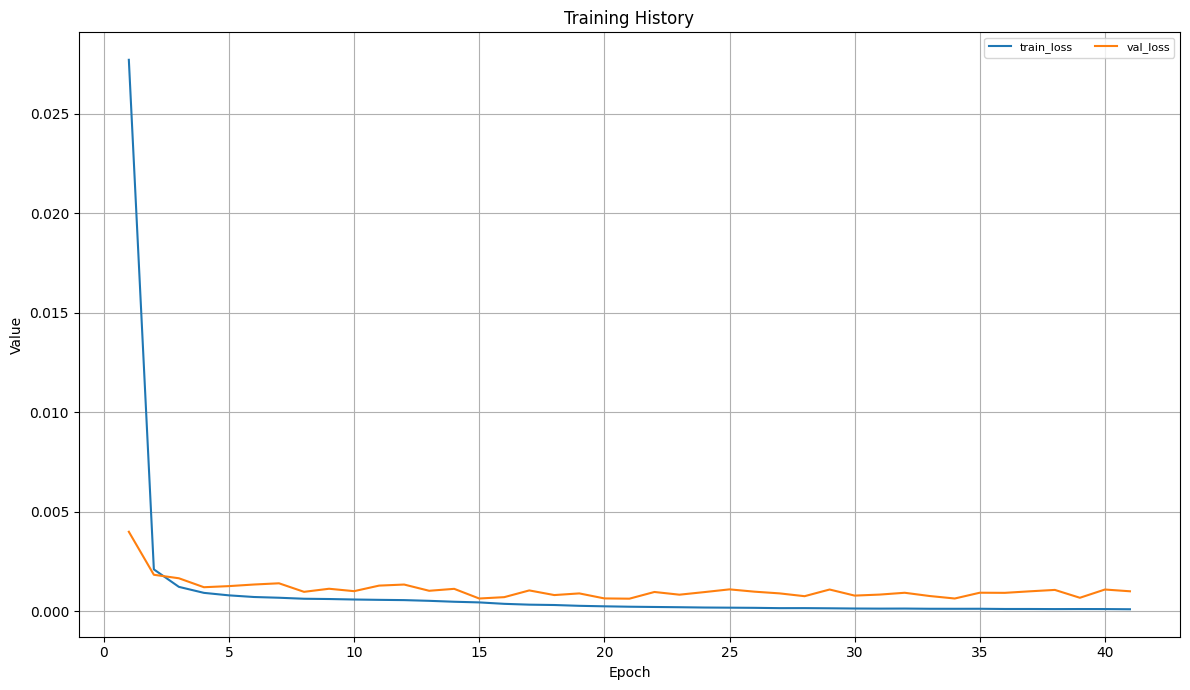

In [3]:
import json
import matplotlib.pyplot as plt

json_path = r"C:\Users\qiyuanxu\Desktop\Scope 1\CAE_validate_clear-20260227105256\history.json"

with open(json_path, "r") as f:
    history = json.load(f)

keys_to_plot = [
    "train_loss",
    "val_loss",
    # "val_overall_mae",
    # "val_overall_mse",
    # "val_overall_rmse",
]

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 7))
for key in keys_to_plot:
    plt.plot(epochs, history[key], label=key)

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training History")
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()